# Setting

In [1]:
import numpy as np
import pymc3 as pm
import os, math, re
import arviz as az
import pandas as pd

from scipy.special import comb
from scipy.stats import poisson, binom, chi2_contingency, beta
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

%load_ext autotime

time: 840 µs (started: 2023-04-27 19:39:57 +09:00)


In [2]:
def print_machine_type(thold_cpu=None, thold_mem=None):
    """ system info """
    cpu_count = os.cpu_count()
    tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
    mem_gb = round(tot_m/1024)
    print(f'{cpu_count} vCPUs, {mem_gb} GB RAM')
    for name, val, thold in [['cpu', cpu_count, thold_cpu],['mem', mem_gb, thold_mem]]:
        if thold is not None:
            if val < thold:
                print(f'{name} {val} less than the threshold {thold}')
    return (cpu_count, mem_gb)

time: 1.86 ms (started: 2023-04-27 19:39:57 +09:00)


In [3]:
def print_interval(low, high, text='confidence interval: '):
    #low, high = low*100, high*100
    p = (low+high)/2
    err = high - p
    #print(f'{text}{p:.3f} ± {err:.4f}, [{low:.3f}, {high:.3f}]')
    print(f'{text}{p} ± {err}, [{low}, {high}]')
    

def test_hypothesis(pvalue, level=0.95):
    alpha = 1 - level
    if pvalue > alpha:
        s = 'Accept'
    else:
        s = 'Reject'
    print(f'{s} H0 (p-value = {pvalue:.4e})')

time: 1.77 ms (started: 2023-04-27 19:39:57 +09:00)


## Utils for Bayesian Inference

In [31]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)


def get_num_prior(num, trace, prefix='number'):
    param = f'{prefix}_{num:02}'
    samples = trace[param]
    return from_posterior(param, samples)    


def plot_number(traces_num, ax, ref_val=1/45, step=1):
    #cmap = mpl.cm.autumn
    cmap = mpl.cm.bone
    len_tr = len(traces_num)
    for update_i, samples in enumerate(traces_num, start=1):
        if update_i%step > 0:
            continue
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = gaussian_kde(samples)(x)
        ax.plot(x, y, color=cmap(1 - update_i/len_tr))
    #ax.axvline(ref_val, c="k")
    ax.axvline(ref_val, c="darkblue", ls='--')
    return ax


def plot_numbers(traces, varns, ref_val=1/45,
                 dim=(15, 3), figsize=(14,50)):
    sp_rows, sp_cols = dim 
    fig, axes = plt.subplots(sp_rows, sp_cols, figsize=figsize)

    for i,v in enumerate(sorted(varns)):
        n1, n2 = i//sp_cols, i%sp_cols
        ax = plot_number(traces[v], axes[n1][n2], ref_val)
        ax.set_title(v)
        ax.xaxis.set_major_locator(mticker.NullLocator())
        
 

time: 3.56 ms (started: 2023-04-27 19:47:15 +09:00)


In [32]:
def plot_numbers_az(trace, 
                    num_list=list(range(1,46)), 
                    ref_val=1/45,
                    dim=(15, 3), figsize=(14,50)):
    sp_rows, sp_cols = dim 
    fig, axes = plt.subplots(sp_rows, sp_cols, figsize=figsize)

    for i,v in enumerate(sorted(num_list)):
        n1, n2 = i//sp_cols, i%sp_cols
        _ = az.plot_posterior(trace, 
                              var_names=['numbers'], coords = {'nidx': v},
                              ref_val=ref_val, 
                              textsize=12,
                              ax=axes[n1][n2])
        axes[n1][n2].set_title(v)
        axes[n1][n2].xaxis.set_major_locator(mticker.NullLocator())

time: 1.91 ms (started: 2023-04-27 19:47:16 +09:00)


# Q1 2등 당첨 확률

- 지난 4일 추첨이 된 1057회 로또 당첨 번호는 '8, 13, 19, 27, 40, 45'였고 2등 보너스 번호는 '12'였다. 
- 당첨 번호 5개와 보너스 번호가 일치한 2등은 전국에서 664장이 나왔다. 2등 당첨 664장 중 103장이 서울 동대문구 왕산로 복권 판매점에서 동시에 나온 것으로 알려져
- 해당 판매점에서 당첨된 2등 103장 중 '자동'은 1장, '수동'은 102장이었으며 '수동' 102장 중 100장은 같은 날짜, 같은 시간대에 판매돼 같은 사람이 구매한 것으로 추정
- 복권위는 "2등 당첨 확률은 136만분의 1로서 1057회차 판매량이 1억1252만장이었던 것을 고려하면 구매자가 균등하게 번호 조합을 선택할 경우 당첨자는 83명 내외 발생한다"고 설명.
- "하지만 현실에서는 구매자 선호 번호, 기존 회차 당첨 번호, 가로·세로·대각선과 같은 구매 용지 번호 배열 패턴 등 구매자 선택에 따라 이번 회차처럼 당첨자가 많을 수도 있고 극단적으로 1명까지 적어질 가능성도 존재"

결과:
- 로또 6/45의 2등 당첨 확률은 이상적인 경우(45개 모든 숫자의 추첨 확률은 동일하고, 구매자들이 균등하게 번호 조합을 선택할 경우) 136만분의 1
- 이상적인 경우 2등은 99% 신뢰수준에서 59에서 106장 사이
- 실제로는 2등 664장(당첨 비율은 17만분의 1)으로 구매자들의 균등한 번호 조합을 가정할 수 없는 상황.
- 판매된 복권의 모든 6개 번호 조합은 모두 동일한 비율로 존재(균등한 번호 조합)한다면, 포아송 분포를 가정할 때 2등 당첨자수는 60~107장으로 이항분포로 가정한 2등 당첨확률에 의한 당첨자수와 유사(당연) 
- 다른 등수에 대해 검토한 결과 1등을 제외하고 모두 실제 당첨자수는 균등한 번호 조합을 가정한 당첨자수의 범위 밖.

In [29]:
n_game = 112520000 #  1057회차 판매장수
N = 45
num = 6
n_win2 = 664

time: 1.07 ms (started: 2023-04-27 15:23:57 +09:00)


## Q11. 이상적인 조건
- 45개 모든 숫자의 추첨 확률은 동일
- 균등한 번호 조합: 판매된 복권의 모든 6개 번호 조합은 모두 동일한 비율로 존재

In [30]:
k = 5

# 1등 당첨 번호 6개중 5개는 1등과 같고 한 개만 보너스와 같은 번호
#p2 = comb(num, k) * comb(num-k,1) * comb(N-num-1, 0) / comb(N,num)
p2 = comb(num, 1) / comb(N,num)

print(f'2등 당첨 확률: {1/p2:,.0f}분의 1')
p2

2등 당첨 확률: 1,357,510분의 1


7.3664282399393e-07

time: 22.9 ms (started: 2023-04-27 15:24:00 +09:00)


In [31]:
print(f'판매량 {n_game:,}장일 때 당첨자는 {p2 * n_game:.0f}명 내외 발생')

판매량 112,520,000장일 때 당첨자는 83명 내외 발생
time: 6.38 ms (started: 2023-04-27 15:24:02 +09:00)


In [33]:
n = n_game
k = p2 * n_game

level = 0.99
alpha = 1 - level
method = 'normal'
low_high = proportion_confint(k, n, alpha, method=method)

x = [round(x*n) for x in low_high] 
print(f'{level*100:.0f}% 신뢰수준에서 2등 당첨자수는 {x[0]}~{x[1]}명')

99% 신뢰수준에서 2등 당첨자수는 59~106명
time: 16.8 ms (started: 2023-04-27 15:24:48 +09:00)


In [34]:
low_high

(5.282270722711393e-07, 9.450585757167208e-07)

time: 10 ms (started: 2023-04-27 15:25:11 +09:00)


## Q12. 실제 결과

In [35]:
obs = n_win2
p = obs/n_game
print(f'실제 2등 당첨 비율: {1/p:,.0f}분의 1')

실제 2등 당첨 비율: 169,458분의 1
time: 1.28 ms (started: 2023-04-27 15:25:17 +09:00)


In [36]:
level = 0.99

# 모든 조합 수가 동일
mu = n_game / comb(N,num)

x = poisson.interval(level, mu)
print(f'{level*100:.0f}% 신뢰수준에서 균등한 번호 조합 시 각 숫자 빈도: {x[0]:.0f}~{x[1]:.0f}회')

mu = obs / 6
print(f'실제 2등 조합 6개 각각은 {mu:.0f}장이므로 균등한 번호 조합을 가정할 수 없다')

99% 신뢰수준에서 균등한 번호 조합 시 각 숫자 빈도: 5~24회
실제 2등 조합 6개 각각은 111장이므로 균등한 번호 조합을 가정할 수 없다
time: 11.9 ms (started: 2023-04-27 15:25:24 +09:00)


In [37]:
level = 0.99

# 2등의 번호 조합은 6개
mu = n_game / comb(N,num) * 6

x = poisson.interval(level, mu)
print(f'균등한 번호 조합 시 포아송 분포를 가정한 2등 당첨장 수: {x[0]:.0f}~{x[1]:.0f}장 ({level*100:.0f}% 신뢰수준)')

print(f'실제 2등은 {obs:.0f}장이므로 균등한 번호 조합을 가정할 수 없다')

균등한 번호 조합 시 포아송 분포를 가정한 2등 당첨장 수: 60~107장 (99% 신뢰수준)
실제 2등은 664장이므로 균등한 번호 조합을 가정할 수 없다
time: 11.6 ms (started: 2023-04-27 15:25:27 +09:00)


## Q13. 각 등수별 당첨자 수
- 1057회 1~5등 순서대로 당첨게임 수: 17, 664, 2,962, 146,471, 2,461,495
- 1057회차 판매량이 1억1252만장

In [38]:
n_game = 112520000 #  1057회차 판매장수
N = 45
num = 6
n_win2 = [17, 664, 2962, 146471, 2461495]

time: 6.04 ms (started: 2023-04-27 15:33:13 +09:00)


In [42]:
pw = [0]*5
pw[0] = 1/comb(N,num)
pw[1] = 6 * p1
pw[2] = comb(num, 5) * comb(num-5,0) * comb(N-num-1, 1) * p1
pw[3] = comb(num, 4) * comb(N-num, num-4) * p1 
pw[4] = comb(num, 3) * comb(N-num, num-3) * p1 

time: 3.26 ms (started: 2023-04-27 15:43:01 +09:00)


In [46]:
# 2항 분포
level = 0.99
alpha = 1 - level
method = 'normal'

for i, p in enumerate(pw):
    low_high = proportion_confint(p*n_game, n_game, alpha, method=method)
    x = [round(x*n_game) for x in low_high] 
    print(f'{i+1}등 당첨자수는 이론상 {x[0]:,}~{x[1]:,}명, 실제 {n_win2[i]:,}명')

1등 당첨자수는 이론상 4~23명, 실제 17명
2등 당첨자수는 이론상 59~106명, 실제 664명
3등 당첨자수는 이론상 3,005~3,294명, 실제 2,962명
4등 당첨자수는 이론상 152,540~154,557명, 실제 146,471명
5등 당첨자수는 이론상 2,520,969~2,529,063명, 실제 2,461,495명
time: 12 ms (started: 2023-04-27 15:44:21 +09:00)


In [48]:
# 포아송 분포
level = 0.99
alpha = 1 - level
method = 'normal'

for i, p in enumerate(pw):
    mu = p * n_game
    x = poisson.interval(level, mu)
    print(f'{i+1}등 당첨자수는 이론상 {x[0]:,.0f}~{x[1]:,.0f}명, 실제 {n_win2[i]:,}명')

1등 당첨자수는 이론상 5~24명, 실제 17명
2등 당첨자수는 이론상 60~107명, 실제 664명
3등 당첨자수는 이론상 3,006~3,295명, 실제 2,962명
4등 당첨자수는 이론상 152,540~154,559명, 실제 146,471명
5등 당첨자수는 이론상 2,520,924~2,529,110명, 실제 2,461,495명
time: 15.8 ms (started: 2023-04-27 15:48:30 +09:00)


# Q2. 숫자별 추첨 확률

## Setting

In [5]:
n_pool = 45
n_select = 6

# jackpot probability
p_jp_ref = 1/comb(n_pool, n_select)
p_jp_ref

1.2277380399898834e-07

time: 14.1 ms (started: 2023-04-27 19:39:59 +09:00)


In [6]:
# a number draw probability
p_num_ref = 1/n_pool
p_num_ref

0.022222222222222223

time: 12.2 ms (started: 2023-04-27 19:40:00 +09:00)


## Historical
엑셀다운로드: https://dhlottery.co.kr/gameResult.do?method=byWin

In [7]:
file = 'lottery_history2.csv'
df_all = pd.read_csv(file, index_col=0)

time: 46.6 ms (started: 2023-04-27 19:40:01 +09:00)


In [8]:
# Jackpot Numbers
df_numbers = df_all[['1','2','3','4','5','6','보너스']]

time: 6.55 ms (started: 2023-04-27 19:40:02 +09:00)


In [9]:
df = df_all.copy()
cols = ['당첨금액','당첨금액.1','당첨금액.2','당첨금액.3','당첨금액.4']
df[cols] = df[cols].apply(lambda x: x.str.rstrip('원').str.replace(',','').astype(int))
df

,추첨일,당첨자수,당첨금액,당첨자수.1,당첨금액.1,당첨자수.2,당첨금액.2,당첨자수.3,당첨금액.3,당첨자수.4,당첨금액.4,1,2,3,4,5,6,보너스
회차,,,,,,,,,,,,,,,,,,
1064,2023.04.22,19,1348168106,62,68858049,3296,1295267,158665,50000,2525390,5000,3,6,9,18,22,35,14
1063,2023.04.15,7,3770311875,55,79976313,2706,1625535,139518,50000,2401618,5000,3,6,22,23,24,38,30
1062,2023.04.08,7,3801933804,68,65229257,2668,1662515,133599,50000,2278058,5000,20,31,32,40,41,45,12
1061,2023.04.01,11,2422768773,99,44866089,3003,1479102,145857,50000,2425576,5000,4,24,27,35,37,45,15
1060,2023.03.25,28,898238907,96,43664392,4593,912646,179475,50000,2566118,5000,3,10,24,33,38,45,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2003.01.04,0,0,0,0,42,6033800,3043,166500,60434,10000,16,24,29,40,41,42,3
4,2002.12.28,0,0,1,211191200,29,7282400,2777,152100,52382,10000,14,27,30,31,40,42,2
3,2002.12.21,1,2000000000,0,0,139,1174100,5940,54900,73256,10000,11,16,19,21,27,31,30


time: 104 ms (started: 2023-04-27 19:40:04 +09:00)


In [10]:
# 2004년 8월 1일부터 규정을 변경, 게임당 2,000원에서 1,000원으로 가격을 내리고 이월 횟수도 2회로 줄이면서 평균 당첨 금액도 10억 중반 대로 상당히 줄어들었다.

# 최초에는 4등 당첨금도 배당률에 의해 유동적이었으나 당첨금이 과세기준인 5만 원을 넘을 경우, 배당률이 높은데 수령금은 더 적어지는 문제가 있어 
# 2010년 8월부터 5만 원 정액으로 바뀌었다. 그 후 당첨금을 판매점에서 지급하게 되었다.

# 1등의 당첨금 배분 비율: 총 당첨금 중 4등과 5등 금액을 제외한 금액의 75%

# 총 당첨금은 로또 전체 판매액의 50%이며, 42% 이상은 복권기금으로 활용됩니다.

index_i = df.loc[df['당첨자수']==0].index.max()+2
df = df.loc[df.index >= index_i] # 최종 이월 다음부터 회차만 고려
df

,추첨일,당첨자수,당첨금액,당첨자수.1,당첨금액.1,당첨자수.2,당첨금액.2,당첨자수.3,당첨금액.3,당첨자수.4,당첨금액.4,1,2,3,4,5,6,보너스
회차,,,,,,,,,,,,,,,,,,
1064,2023.04.22,19,1348168106,62,68858049,3296,1295267,158665,50000,2525390,5000,3,6,9,18,22,35,14
1063,2023.04.15,7,3770311875,55,79976313,2706,1625535,139518,50000,2401618,5000,3,6,22,23,24,38,30
1062,2023.04.08,7,3801933804,68,65229257,2668,1662515,133599,50000,2278058,5000,20,31,32,40,41,45,12
1061,2023.04.01,11,2422768773,99,44866089,3003,1479102,145857,50000,2425576,5000,4,24,27,35,37,45,15
1060,2023.03.25,28,898238907,96,43664392,4593,912646,179475,50000,2566118,5000,3,10,24,33,38,45,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,2011.11.26,4,3330131250,33,67275379,1277,1738519,65880,50000,1125554,5000,4,21,22,34,37,38,33
468,2011.11.19,9,1527197167,33,69418054,1457,1572269,70701,50000,1187572,5000,8,13,15,28,37,43,17
467,2011.11.12,9,1435441084,33,65247322,1811,1188936,88314,50000,1410192,5000,2,12,14,17,24,40,39


time: 62.7 ms (started: 2023-04-27 19:40:08 +09:00)


In [11]:
# 1등 당첨수
df_jp = df['당첨자수'].to_frame('n_winners')

# 게임수
df_jp['n_sold'] = (df['당첨금액'].multiply(df_jp['n_winners'])
             .div(0.75)
             .add(df['당첨금액.3'].multiply(df['당첨자수.3']))
             .add(df['당첨금액.4'].multiply(df['당첨자수.4']))
             .div(0.5) # 이상 총판매금액
             .div(1000).rename('게임수')
             .astype(int)
)

df_jp

,n_winners,n_sold
회차,,
1064,19,109427584
1063,7,108347135
1062,7,107109911
1061,11,109909344
1060,28,110677185
...,...,...
469,4,53364940
468,9,55598552
467,9,57383906


time: 39.9 ms (started: 2023-04-27 19:40:11 +09:00)


In [13]:
# 확인
#a = 102804882000 # 1019회: 총판매금액 
a = 109427584000 # 1064회
u = 1000
n = int(a/u) # number of tickets sold
print(f'{n:.5e}')

x = df_jp.loc[1064, 'n_sold']
print(f'{x:.5e}')

1.09428e+08
1.09428e+08
time: 4.17 ms (started: 2023-04-27 19:40:53 +09:00)


## Hypothesis Test
- H0: All the numbers have the same probability (1/45)

In [14]:
# the ideal probability of a number to choose
p_num_ref

0.022222222222222223

time: 6.02 ms (started: 2023-04-27 19:41:00 +09:00)


In [15]:
level = 0.95
#level = 0.99
n = df_numbers.stack().count()

b1 = binom.ppf((1-level)/2, n, p_num_ref)
b2 = binom.ppf((1+level)/2, n, p_num_ref)

time: 8.23 ms (started: 2023-04-27 19:41:02 +09:00)


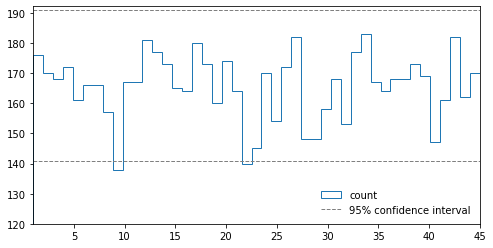

time: 470 ms (started: 2023-04-27 19:41:57 +09:00)


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

df_numbers.stack().hist(bins=45, histtype='step', grid=False, ax=ax)

kw = {'ls':'--', 'lw':1, 'c':'grey'}
ax.axhline(b1, **kw)
ax.axhline(b2, **kw)
ax.set_xlim([1,45])
ax.set_ylim(120)
#ax.set_title(f'{level*100:.0f}% confidence interval')
ax.legend(['count', f'{level*100:.0f}% confidence interval'], 
          loc='lower right', frameon=False)
plt.show()

In [21]:
n = df_numbers.stack().count()
df = df_numbers.stack().value_counts().to_frame('num of drawn').sort_index()
df['not drawn'] = n-df
df.T

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
num of drawn,176,170,168,172,161,166,166,157,138,167,...,164,168,168,173,169,147,161,182,162,170
not drawn,7272,7278,7280,7276,7287,7282,7282,7291,7310,7281,...,7284,7280,7280,7275,7279,7301,7287,7266,7286,7278


time: 60.9 ms (started: 2023-04-27 19:42:29 +09:00)


H0 cannot be rejected even though the count of number 9 exceeds the 95% confidence interval

In [22]:
# accept H0: 번호와 추첨 간 상관관계가 없다(독립). 즉 특정 번호가 더 많이 혹은 더 적게 추첨되었다고 할 수 없다
res = chi2_contingency(df.T)
test_hypothesis(res[1])

Accept H0 (p-value = 8.7926e-01)
time: 10.9 ms (started: 2023-04-27 19:42:34 +09:00)


## Inference by Number Frequencies

### Beta for Prior

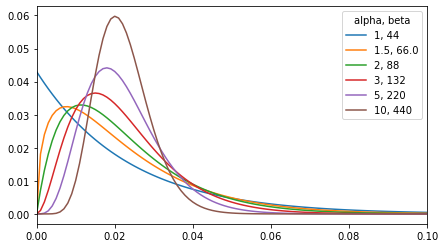

time: 664 ms (started: 2023-04-27 19:42:40 +09:00)


In [23]:
alphas = [1,1.5,2,3,5,10]
params = [(x, x*(n_pool-1)) for x in alphas]

theta = np.arange(0,1.01,.001)

fig,ax = plt.subplots(1,1, figsize=(7,4))
for a,b in params:
    prior_beta  = beta(a,b)
    prior_beta = prior_beta.pdf(theta) / prior_beta.pdf(theta).sum() # sample integral pmf
    ax.plot(theta, prior_beta, label=f'{a}, {b}')
ax.set_xlim([0, 0.1])
ax.legend(title='alpha, beta')
plt.show()

### Modelling

In [24]:
draws = df_numbers.stack().count()
freqs = df_numbers.stack().value_counts().sort_index()
draws, freqs

(7448,
 1     176
 2     170
 3     168
 4     172
 5     161
 6     166
 7     166
 8     157
 9     138
 10    167
 11    167
 12    181
 13    177
 14    173
 15    165
 16    164
 17    180
 18    173
 19    160
 20    174
 21    164
 22    140
 23    145
 24    170
 25    154
 26    172
 27    182
 28    148
 29    148
 30    158
 31    168
 32    153
 33    177
 34    183
 35    167
 36    164
 37    168
 38    168
 39    173
 40    169
 41    147
 42    161
 43    182
 44    162
 45    170
 dtype: int64)

time: 30.9 ms (started: 2023-04-27 19:42:44 +09:00)


In [25]:
# 1 < sigma < sqrt(mu * (1 - mu))
mu = p_num_ref
sigma = 0.1
np.sqrt(mu * (1 - mu)) # max of sigma

0.14740554623801777

time: 11 ms (started: 2023-04-27 19:42:47 +09:00)


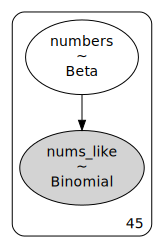

time: 14.2 s (started: 2023-04-27 19:42:50 +09:00)


In [26]:
num_idxs = freqs.index.to_list()

# far more faster than not using coords
with pm.Model(coords={'nidx': num_idxs}) as model:
    numbers = pm.Beta('numbers', mu=mu, sigma=sigma, dims='nidx')
    nums_like = pm.Binomial('nums_like', n=draws, p=numbers, observed=freqs, dims='nidx')
    
pm.model_to_graphviz(model=model)

### Sampling

In [27]:
#n_tune, n_draws, n_chains = 1000, 1000, None
n_tune, n_draws, n_chains = 5000, 10000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                       #target_accept=0.95,
                       return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [numbers]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 141 seconds.


time: 2min 35s (started: 2023-04-27 19:43:04 +09:00)


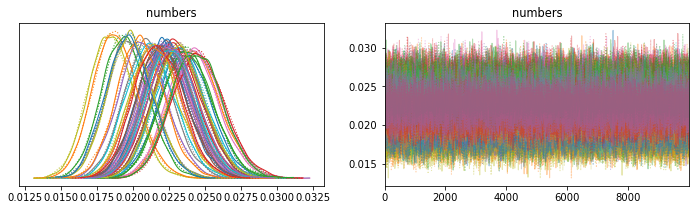

time: 9.66 s (started: 2023-04-27 19:45:40 +09:00)


In [28]:
figsize = (12, 1*3)
_ = az.plot_trace(trace, figsize=figsize)

#### Posteriors

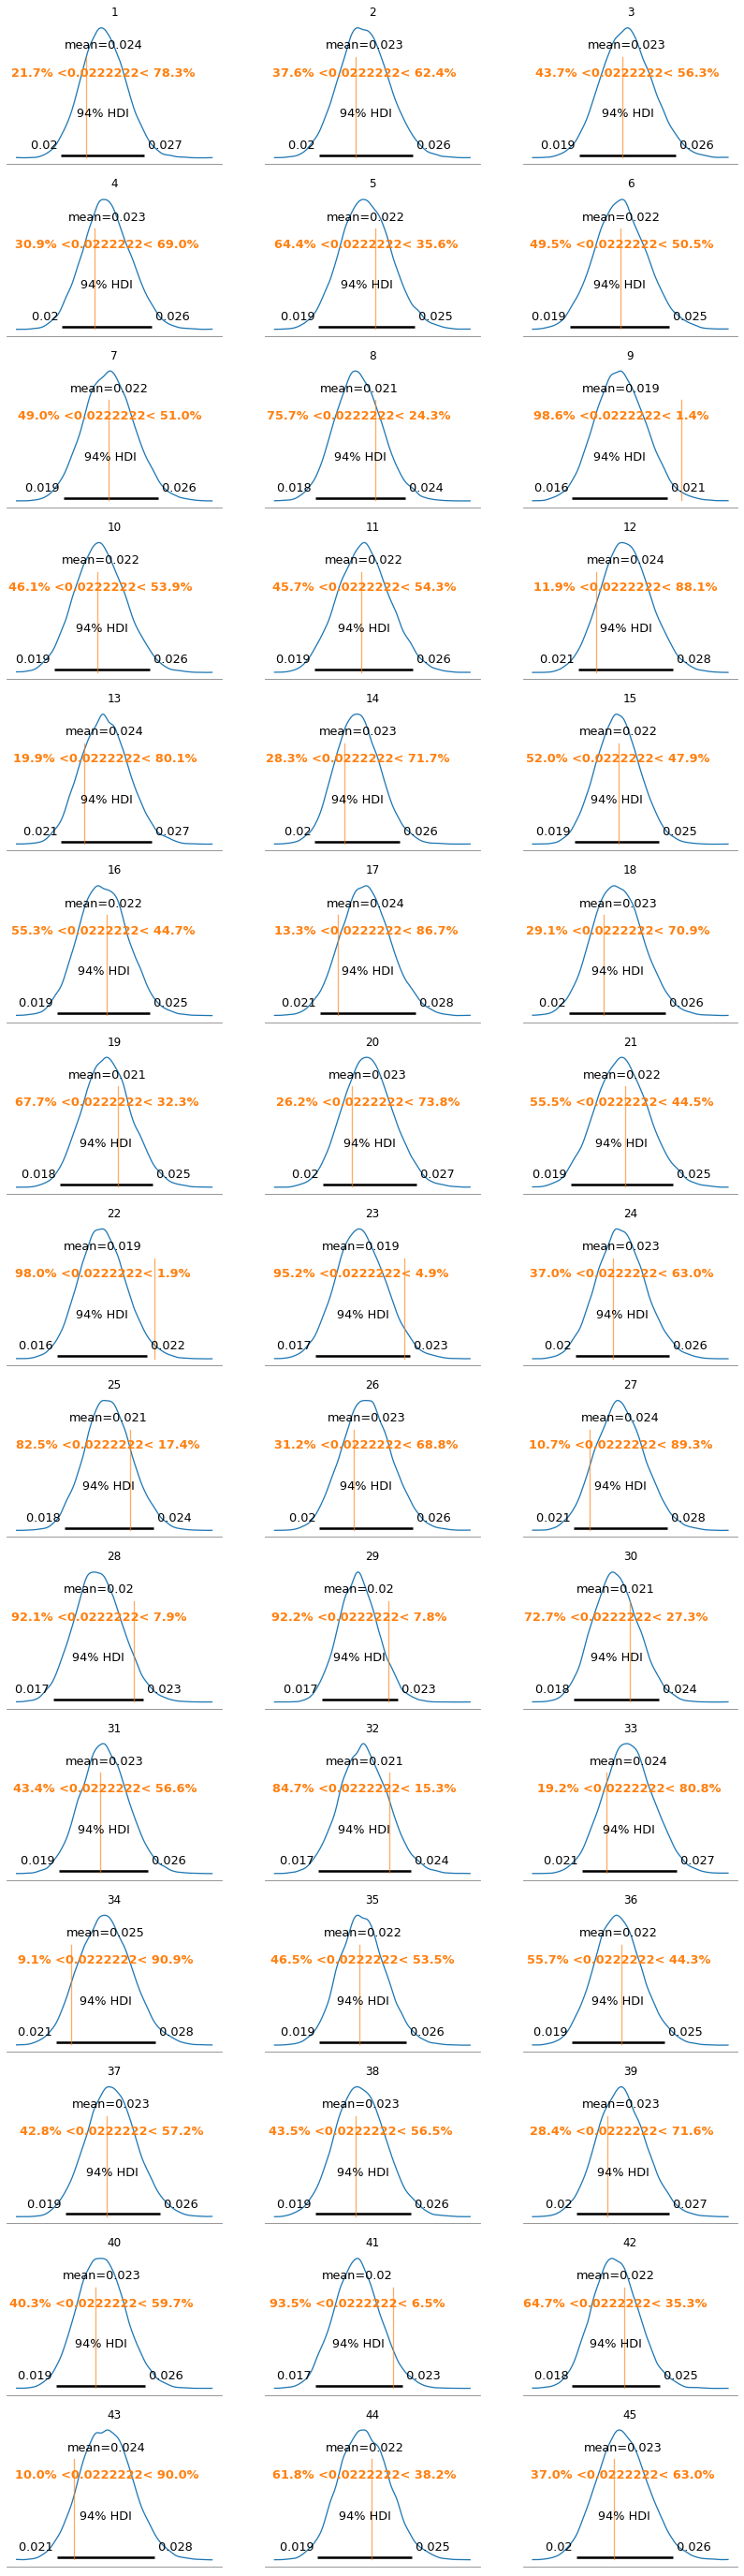

time: 9.1 s (started: 2023-04-27 19:47:26 +09:00)


In [33]:
plot_numbers_az(trace)

plot number not in confidence interval

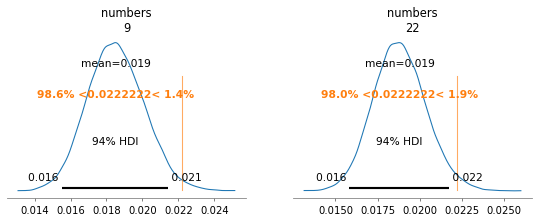

time: 3.27 s (started: 2023-04-27 19:47:43 +09:00)


In [34]:
df = az.summary(trace)
hdi_l, hdi_u = [x for x in df.columns if x.startswith('hdi')]
idx = df.loc[df.apply(lambda x: max(x[hdi_l]-p_num_ref, p_num_ref-x[hdi_u], 0), axis=1) > 0].index
expr = '\[([\d]+)\]'
nums = [int(re.search(expr, x)[1]) for x in idx]

_ = az.plot_posterior(trace, ref_val=p_num_ref, 
                      var_names='numbers', coords = {'nidx': nums},
                      figsize=(len(nums)*4.7, 3), textsize=10)